<a href="https://colab.research.google.com/github/Masterpiece-Image/Unfolding/blob/main/src/ChefdOeuvre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from tqdm import tqdm
device_cpu = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.index, device_cpu.index

(None, None)

In [2]:
import torch
import torch.utils.data

import torchvision
import torchvision.io
import torchvision.transforms


import pathlib
import os


# Dataset customization : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class ImageDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir: pathlib.Path) -> None:
        """
        Args:
            root_dir (pathlib.Path): Directory with all the images.
        """
        super().__init__()
        self.root_dir: pathlib.Path = root_dir
        self.image_names: list[pathlib.Path] = [ filename.stem for filename in map(lambda e : pathlib.Path(e), os.listdir(root_dir / 'Artifacts')) ]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index):
        
        filename_artifact: pathlib.Path = self.root_dir / 'Artifacts' / (self.image_names[index] + '.jpg')
        image_artifact_string: torch.Tensor = torchvision.io.read_file(str(filename_artifact))
        image_artifact_decoded: torch.Tensor = torchvision.io.decode_jpeg(input=image_artifact_string, mode=torchvision.io.ImageReadMode.GRAY) / 255.0

        filename_result: pathlib.Path = self.root_dir / 'Results' / (self.image_names[index] + '.png')
        image_result_string: torch.Tensor = torchvision.io.read_file(str(filename_result))
        image_result_decoded: torch.Tensor = torchvision.io.decode_png(input=image_result_string, mode=torchvision.io.ImageReadMode.GRAY) / 255.0

        image_artifact_decoded = torch.nn.functional.max_pool2d(image_artifact_decoded, (2,2))
        image_result_decoded = torch.nn.functional.max_pool2d(image_result_decoded, (2,2))

        return image_artifact_decoded.squeeze(), image_result_decoded.squeeze()

        # return { 'Artifacts' : image_artifact_decoded, 'Results' : image_result_decoded }

dataset: ImageDataset = ImageDataset(root_dir=pathlib.Path('./datas'))

In [3]:
import torch
import torch.nn as nn
import torch.optim as opti
import torch.utils.data


import matplotlib.pyplot as plt

import typing

        
# data : list<tuple(Tensor, Tensor)>
def train(model : torch.nn.Module, dataset : ImageDataset, num_epochs : int, batch_size : int, learning_rate : float, data_shuffle : bool=True) -> None:

    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = data_shuffle)
    criterion = nn.L1Loss() # MAE
    optimizer = opti.Adam(model.parameters(), lr = learning_rate)

    #pour l'affichage de l'évalution de la loss
    n = 0
    iters, losses = [], []
    # Foreach epochs
    for epoch in tqdm(range(num_epochs)):
        # Foreach batch
        for X, Y in iter(train_loader):
            if X.size()[0] < batch_size:
                continue
            X = torch.unsqueeze(X, 1)
            Y = torch.unsqueeze(Y, 1)
            #print("X device : ", X.device)
            X, Y = X.to(device), Y.to(device)
            #print("X device : ", X.device)
            
            model.train()
            out = model(X)
            
            #loss = criterion(out, Y)
            loss = lossCustom(out, Y, X)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            #mémorise la valeur des la loss pour chaque batch
            iters.append(n)
            #print("X:", X, "\nOut:", out, "\nLoss",loss)
            losses.append(float(loss)/batch_size)
            n -= -1


    #affichage
    plt.title("Courbe d'appentissage")
    plt.plot(iters, losses)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()


def lossCustom(output, target, J):
  O, H = output[0], output[1]
  #alpha = beta = torch.tensor([1 if (i==0) else 0.1 for i in range(O.shape[0])])

  resemblance_loss = torch.abs(O - target.unsqueeze(0)).expand((O.shape[0],-1,-1,-1,-1))
  consistance_loss = torch.abs(H - (J - target).unsqueeze(0)).expand((H.shape[0],-1,-1,-1,-1))

  resemblance_loss = torch.mean(resemblance_loss, dim=(1,2,3,4))
  consistance_loss = torch.mean(consistance_loss, dim=(1,2,3,4))

  #alpha.to(device)
  #beta.to(device)
  #resemblance_loss.to(device)
  #consistance_loss.to(device)

  #print("\ndevice alpha:", alpha.get_device(), ", ", torch.cuda.device(alpha.get_device()))
  #print("device beta:", beta.get_device(), ", ", torch.cuda.device(beta.get_device()))
  #print("device resemblance_loss:", resemblance_loss.get_device(), ", ", torch.cuda.device(resemblance_loss.get_device()))
  #print("device consistance_loss:", consistance_loss.get_device(), ", ", torch.cuda.device(consistance_loss.get_device()))

  resemblance_loss = resemblance_loss * 0.1
  consistance_loss = consistance_loss * 0.
  resemblance_loss[0] *= 10
  consistance_loss[0] *= 10

  loss = torch.mean(resemblance_loss + consistance_loss)

  return loss 

In [4]:
alpha = beta = torch.tensor([1 if (i==0) else 0.1 for i in range(10)])

print("device:", alpha.get_device(), ", ", torch.cuda.device(alpha.get_device()))
alpha.to(device_cpu)
beta.to(device_cpu)
print("device:", alpha.get_device(), ", ", torch.cuda.device(alpha.get_device()))



device: -1 ,  <torch.cuda.device object at 0x7fbdb41b4130>
device: -1 ,  <torch.cuda.device object at 0x7fbdd3f61100>


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional

import typing

class ProximalOperator(torch.nn.Module):


    def __init__(self, in_channels: int, num_features: int) -> None:    
        super().__init__()

        self.in_channels = in_channels

        #scope prox
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=num_features, kernel_size=3, padding="same")
        
        self.conv_it = {}
        for i in range(5):
            self.conv_it["conv_it"+str(i)+"_1"] = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, padding="same")
            self.conv_it["conv_it"+str(i)+"_2"] = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, padding="same")

        self.conv3 = nn.Conv2d(in_channels=num_features, out_channels=in_channels, kernel_size=3, padding="same")
        

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        conv = self.conv(image)
        conv = nn.functional.relu(conv)
        for i in range(5):
            conv_1 = self.conv_it["conv_it"+str(i)+"_1"](conv)
            conv_1 = nn.functional.relu(conv_1)
            conv_2 = self.conv_it["conv_it"+str(i)+"_2"](conv_1)
            conv_2 = nn.functional.relu(conv_2)
            conv = conv_1 + conv_2
        out = self.conv3(conv)
        return out

    def to(self, *args, **kwargs):
        self = super().to(*args, **kwargs)
        for i in self.conv_it:
          self.conv_it[i].to(*args, **kwargs)
        return self



class Prox_M(ProximalOperator):
    def __init__(self, in_channels: int) -> None:
        super().__init__(in_channels=in_channels, num_features=in_channels // 2)


class Prox_O(ProximalOperator):
    def forward(self, image : torch.Tensor) -> torch.Tensor:
        out = super().forward(image)
        B = out[:, 0:1, :, :]
        Z = out[:, 1:self.in_channels, :, :]
        return B, Z


In [9]:
import torch
import torch.nn as nn
# from torch.nn import L1Loss as MAE

import typing

# -----------------------------------------------

# -----------------------------------------------


class Unfolding(torch.nn.Module):


    def __init__(self, in_channels: int, num_features: int = 48, iterations: int = 10) -> None:
        super().__init__()

        self.prox_O: Prox_O = Prox_O(in_channels=in_channels+num_features, num_features=num_features)
        self.prox_M: Prox_M = Prox_M(in_channels=num_features*3)
        self.stepO = torch.tensor(0.1, dtype=torch.double, requires_grad=True)
        self.stepM = torch.tensor(0.1, dtype=torch.double, requires_grad=True)
        self.num_features = num_features
        self.iterations = iterations

        #initial scope
        self.O_0 = nn.Conv2d(in_channels=1, out_channels=num_features, kernel_size=3, padding="same")

        self.conv_it = {}
        for i in range(iterations):
            self.conv_it["conv_it"+str(i)+"X1"] = nn.Conv2d(in_channels=in_channels, out_channels=num_features, kernel_size=3, dilation=1, padding="same", bias=False)
            self.conv_it["conv_it"+str(i)+"X2"] = nn.Conv2d(in_channels=in_channels, out_channels=num_features, kernel_size=3, dilation=2, padding="same", bias=False)
            self.conv_it["conv_it"+str(i)+"X4"] = nn.Conv2d(in_channels=in_channels, out_channels=num_features, kernel_size=3, dilation=4, padding="same", bias=False)
            self.conv_it["conv_it"+str(i)+"X11"] = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, dilation=1, padding="same", bias=False)
            self.conv_it["conv_it"+str(i)+"X22"] = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, dilation=2, padding="same", bias=False)
            self.conv_it["conv_it"+str(i)+"X44"] = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, dilation=4, padding="same", bias=False)
            self.conv_it["conv_it"+str(i)+"X111"] = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, dilation=1, padding="same", bias=False)
            self.conv_it["conv_it"+str(i)+"X222"] = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, dilation=2, padding="same", bias=False)
            self.conv_it["conv_it"+str(i)+"X444"] = nn.Conv2d(in_channels=num_features, out_channels=num_features, kernel_size=3, dilation=4, padding="same", bias=False)

        



    def forward(self, J: torch.Tensor) -> torch.Tensor:
        torch.Tensor : all_O
        torch.Tensor : all_H
        #initial
        O_0 = self.O_0(J)
        a = [O_0,J]
        tmp = torch.concat([O_0,J],1)
        O_previous, Z = self.prox_O(tmp)
        H = J - O_previous

        #iteration 1
        X_1 = self.conv_it["conv_it"+str(0)+"X1"](H)
        X_2 = self.conv_it["conv_it"+str(0)+"X2"](H)
        X_4 = self.conv_it["conv_it"+str(0)+"X4"](H)

        M = self.prox_M(torch.concat([X_1,X_2,X_4],1))

        X_1 = self.conv_it["conv_it"+str(0)+"X11"](M[:,0:self.num_features,:,:])
        X_2 = self.conv_it["conv_it"+str(0)+"X22"](M[:,self.num_features:self.num_features*2,:,:])
        X_4 = self.conv_it["conv_it"+str(0)+"X44"](M[:,self.num_features*2:self.num_features*3,:,:])

        h_current = torch.concat([X_1,X_2,X_4],1)
        H_current = h_current.sum(1).unsqueeze(1)

        O_current = J - H_current
        
        all_O = O_current.unsqueeze(0)
        all_H = H_current.unsqueeze(0)

        tmp = torch.concat([Z, self.stepO * O_current + (1.-self.stepO) * O_previous],1)
        O_current, Z = self.prox_O(tmp)

        for i in range(1, self.iterations):
            O_previous = O_current
            H = J - O_previous

            X_1 = self.conv_it["conv_it"+str(i)+"X11"](M[:,0:self.num_features,:,:])
            X_2 = self.conv_it["conv_it"+str(i)+"X22"](M[:,self.num_features:self.num_features*2,:,:])
            X_4 = self.conv_it["conv_it"+str(i)+"X44"](M[:,self.num_features*2:self.num_features*3,:,:])

            H_star = torch.concat([X_1,X_2,X_4],1)
            H_star = H_star.sum(1).unsqueeze(1)

            X_1 = self.conv_it["conv_it"+str(i)+"X1"](H_star-H)
            X_2 = self.conv_it["conv_it"+str(i)+"X2"](H_star-H)
            X_4 = self.conv_it["conv_it"+str(i)+"X4"](H_star-H)

            M = self.prox_M(M - self.stepM * torch.concat([X_1,X_2,X_4],1))

            X_1 = self.conv_it["conv_it"+str(i)+"X111"](M[:,0:self.num_features,:,:])
            X_2 = self.conv_it["conv_it"+str(i)+"X222"](M[:,self.num_features:self.num_features*2,:,:])
            X_4 = self.conv_it["conv_it"+str(i)+"X444"](M[:,self.num_features*2:self.num_features*3,:,:])

            h_current = torch.concat([X_1,X_2,X_4],1)
            H_current = h_current.sum(1).unsqueeze(1)
 

            O_current = J - H_current
            tmp = torch.concat([Z, self.stepO * O_current + (1.-self.stepO) * O_previous],1)
            O_current, Z = self.prox_O(tmp)

            all_O = torch.cat((O_current.unsqueeze(0), all_O), dim=0)
            all_H = torch.cat((H_current.unsqueeze(0), all_H), dim=0)

        return (all_O, all_H)


    def to(self, *args, **kwargs):
        self = super().to(*args, **kwargs)
        for i in self.conv_it:
          self.conv_it[i].to(*args, **kwargs)
        self.prox_O.to(*args, **kwargs)
        self.prox_M.to(*args, **kwargs)
        return self

torch.cuda.FloatTensor
torch.cuda.FloatTensor


100%|██████████| 50/50 [04:52<00:00,  5.85s/it]


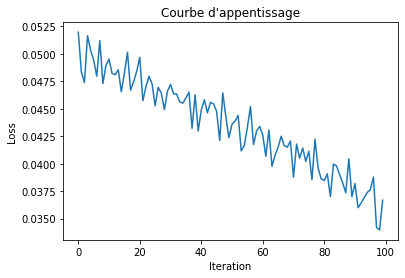

In [7]:
dataset = ImageDataset(root_dir=pathlib.Path('./datas'))
model: Unfolding = Unfolding(in_channels=1)
model.to(device)
print(model.O_0.weight.type())
print(model.prox_O.conv.weight.type())
losses = train(model, dataset, num_epochs=50, batch_size=2, learning_rate=0.0001, data_shuffle=True)

In [8]:
losses